# Notebook for the project in *TDT4259 - Applied Data Science*

Necessary imports

In [10]:
import sys
import warnings
from pathlib import Path

import tikzplotlib

warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

sys.path.append(".")

from util.dataset_manipulation import get_and_process_df
from util.model_utils import train_test_model

from dmba import plotDecisionTree

FIG_PATH = Path.cwd().joinpath("figures")

We start by preprocessing the columns to be on a concise format.

In [11]:
dataset = get_and_process_df("train_data.csv")
desc_dataset = get_and_process_df("train_data.csv", False)

## Creating some descriptive statistics

In [12]:
attrition_pr_city = desc_dataset.groupby("City")["Attrition"].count()

AttributeError: 'Legend' object has no attribute '_ncol'

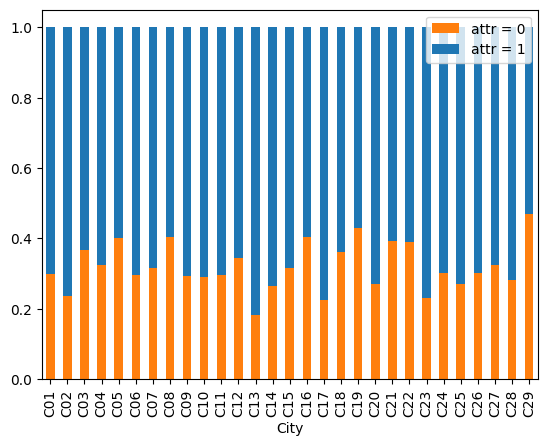

In [13]:
attrition_0 = desc_dataset.groupby('City')['Attrition'].apply(lambda x: (x == 0).sum()).reset_index(name='attr = 0')
attrition_1 = desc_dataset.groupby('City')['Attrition'].apply(lambda x: (x == 1).sum()).reset_index(name='attr_1')

combined = attrition_0.copy()
combined["attr = 0"] = combined["attr = 0"].astype("int")
combined["attr = 1"] = attrition_1.attr_1.astype("int")

combined = combined.set_index(pd.Index(combined.City))
combined = combined.drop("City", axis=1)

combined = combined.div(combined.sum(axis=1), axis=0)

combined.plot(kind="bar", stacked=True, color=['#ff7f0e', '#1f77b4'])

tikzplotlib.save(FIG_PATH.joinpath("group_by_city.tex"))

In [ ]:
attrition_0 = desc_dataset.groupby('Gender')['Attrition'].apply(lambda x: (x == 0).sum()).reset_index(name='attr = 0')
attrition_1 = desc_dataset.groupby('Gender')['Attrition'].apply(lambda x: (x == 1).sum()).reset_index(name='attr = 1')

combined = attrition_0.copy()
combined["attr = 0"] = combined["attr = 0"].astype("int")
combined["attr = 1"] = attrition_1['attr = 1'].astype("int")

combined = combined.set_index(pd.Index(combined.Gender))
combined = combined.drop("Gender", axis=1)

combined = combined.div(combined.sum(axis=1), axis=0)

combined.plot(kind="bar", color=['#ff7f0e', '#1f77b4'], stacked=True)

tikzplotlib.save(FIG_PATH.joinpath("group_by_gender.tex"))

In [ ]:
attrition_0 = desc_dataset.groupby('Education_Level')['Attrition'].apply(lambda x: (x == 0).sum()).reset_index(
    name='attr = 0')
attrition_1 = desc_dataset.groupby('Education_Level')['Attrition'].apply(lambda x: (x == 1).sum()).reset_index(
    name='attr = 1')

combined = attrition_0.copy()
combined["attr = 0"] = combined["attr = 0"].astype("int")
combined["attr = 1"] = attrition_1['attr = 1'].astype("int")

combined = combined.set_index(pd.Index(combined.Education_Level))
combined = combined.drop("Education_Level", axis=1)

combined = combined.div(combined.sum(axis=1), axis=0)

combined.plot(kind="bar", color=['#ff7f0e', '#1f77b4'], stacked=True)

tikzplotlib.save(FIG_PATH.joinpath("group_by_education.tex"))

In [ ]:
# TODO: For whatever reason is the delta_designation missing here
attrition_0 = desc_dataset.groupby('delta_designation')['Attrition'].apply(lambda x: (x == 0).sum()).reset_index(
    name='attr = 0')
attrition_1 = desc_dataset.groupby('delta_designation')['Attrition'].apply(lambda x: (x == 1).sum()).reset_index(
    name='attr = 1')

combined = attrition_0.copy()
combined["attr = 0"] = combined["attr = 0"].astype("int")
combined["attr = 1"] = attrition_1['attr = 1'].astype("int")

combined = combined.set_index(pd.Index(combined.delta_designation))
combined = combined.drop("delta_designation", axis=1)

combined = combined.div(combined.sum(axis=1), axis=0)

ax = combined.plot(kind="bar", color=['#ff7f0e', '#1f77b4'], stacked=True)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])

tikzplotlib.save(FIG_PATH.joinpath("group_by_designation.tex"))

In [ ]:
attrition_0 = desc_dataset.groupby('salary_bin')['Attrition'].apply(lambda x: (x == 0).sum()).reset_index(
    name='attr = 0')
attrition_1 = desc_dataset.groupby('salary_bin')['Attrition'].apply(lambda x: (x == 1).sum()).reset_index(
    name='attr = 1')

combined = attrition_0.copy()
combined["attr = 0"] = combined["attr = 0"].astype("int")
combined["attr = 1"] = attrition_1['attr = 1'].astype("int")

combined = combined.set_index(pd.Index(combined.salary_bin))
combined = combined.drop("salary_bin", axis=1)

combined = combined.div(combined.sum(axis=1), axis=0)

ax = combined.plot(kind="bar", color=['#ff7f0e', '#1f77b4'], stacked=True)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8])

tikzplotlib.save(FIG_PATH.joinpath("group_by_salary.tex"))

# Prototyping some classifications

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = dataset.drop(columns=["Date",
                          "Attrition",
                          "Emp_ID",
                          "Date_Of_Joining",
                          "Last_Working_Date",
                          "Joining_Designation",
                          "Designation",
                          "Total_Business_Value",
                          # "Work_Duration",
                          # "Salary"
                          "salary_bin"
                          ]
                 )
y = dataset["Attrition"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4259)

In [ ]:
from sklearn.svm import SVC

classifier = SVC()
train_test_model(classifier, X_train, y_train, X_test, y_test)

In [ ]:
'''
# Start with an initial guess for parameters
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['sigmoid', 'rbf']} 
# Which values are best?
# n_jobs=-1 will utilize all available CPUs
gridSearch = GridSearchCV(SVC(), param_grid, cv=5,  refit = True, verbose = 0)
gridSearch.fit(X_train, y_train)
print('Initial score: ', gridSearch.best_score_)
print('Initial parameters: ', gridSearch.best_params_)
'''

## Using a Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()

model = train_test_model(dtc, X_train, y_train, X_test, y_test)

In [ ]:
from sklearn.model_selection import GridSearchCV

'''
# Start with an initial guess for parameters
param_grid = {
'max_depth': [10, 20, 30, 40],
'min_samples_split': [20, 40, 60, 80, 100],
'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01],
'criterion': ["gini", "entropy"]
}
# Which values are best?
# n_jobs=-1 will utilize all available CPUs
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(X_train, y_train)
print('Initial score: ', gridSearch.best_score_)
print('Initial parameters: ', gridSearch.best_params_)
'''

In [ ]:
'''
# Adapt grid based on result from initial grid search
param_grid = {
'max_depth': list(range(8, 16)), # 14 values
# 'min_samples_split': list(range(10, 30)), # 11 values
'min_samples_leaf': list(range(70, 100)),
'min_impurity_decrease': [0.001, 0.002, 0.003, 0.004], # 3 values
'criterion': ["entropy"]
}
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(X_train, y_train)
print('Improved score: ', gridSearch.best_score_)
print('Improved parameters: ', gridSearch.best_params_)
bestClassTree = gridSearch.best_estimator_
'''

In [ ]:
dtc = DecisionTreeClassifier(criterion="entropy", max_depth=8, min_impurity_decrease=0.001, min_samples_leaf=70,
                             random_state=4259)

model = train_test_model(dtc, X_train, y_train, X_test, y_test)

In [ ]:
plotDecisionTree(model, feature_names=X_train.columns, pdfFile=FIG_PATH.joinpath("tree.pdf"))

## Using logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lrc = LogisticRegression()
model = train_test_model(lrc, X_train, y_train, X_test, y_test)

In [ ]:
# Start with an initial guess for parameters
param_grid = {
    'penalty': ["none", "l1", "l2", "elasticnet"],
    # 'tol': [20, 40, 60, 80, 100],
    'C': [0.09, 0.1, 0.2, 0.3, 100, 1000]
}
# Which values are best?
# n_jobs=-1 will utilize all available CPUs
gridSearch = GridSearchCV(LogisticRegression(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(X_train, y_train)
print('Initial score: ', gridSearch.best_score_)
print('Initial parameters: ', gridSearch.best_params_)

In [ ]:
coefs = pd.DataFrame([X_train.columns, model.coef_[0]])

In [ ]:
coefs = [list(X_train.columns), model.coef_[0]]
coef = pd.DataFrame(np.array(coefs).transpose())

In [ ]:
print(coef.set_index(coef[0]).to_latex())

In [ ]:
import statsmodels.api as sm

In [ ]:
from util.dataset_manipulation import (get_dataset, create_additional_columns,
                                       clean_attrition_dataset, create_salary_bins)

In [ ]:
def create_categorical_variables(df: pd.DataFrame, create_dummies: bool = True) -> pd.DataFrame:
    '''Creates categorical variables for `Gender`, `City` and `Education_level`'''
    df.Gender = df.Gender.astype("category")
    df.City = df.City.astype("category")
    df.Education_Level = df.Education_Level.astype("category")
    df.delta_designation = df.delta_designation.astype("category")

    if create_dummies:
        df = pd.get_dummies(df, prefix_sep="_", drop_first=True)

    return df

In [ ]:
df = get_dataset("train_data.csv")
df = clean_attrition_dataset(df)
df = create_additional_columns(df)
df = create_categorical_variables(df, True)
df = create_salary_bins(df)

In [ ]:
X = df.drop(columns=["Date",
                     "Attrition",
                     "Emp_ID",
                     "Date_Of_Joining",
                     "Last_Working_Date",
                     "Joining_Designation",
                     "Designation",
                     "Total_Business_Value",
                     # "Work_Duration",
                     # "Salary"
                     "salary_bin"
                     ]
            )
y = df["Attrition"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4259)

In [ ]:
log_reg = sm.Logit(y_train, X_train).fit()

In [ ]:
print(log_reg.summary().as_latex())

In [ ]:
y_hat = log_reg.predict(X_test)
prediction = list(map(round, y_hat))

# comparing original and predicted values of y
# print('Actual values', list(y_test.values))
# print('Predictions :', prediction)

In [ ]:
from sklearn.metrics import (confusion_matrix,
                             accuracy_score)

# confusion matrix
cm = confusion_matrix(y_test, prediction)
print("Confusion Matrix : \n", cm)

# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, prediction))